# CNN Deep Learning Classifier with Tensorflow

In [1]:
import sys

print(sys.executable)
! {sys.executable} -m pip install --upgrade pip 
! {sys.executable} -m pip install tensorflow-gpu
! {sys.executable} -m pip install tensorboard


/anaconda/envs/py35/bin/python
Requirement already up-to-date: pip in /data/anaconda/envs/py35/lib/python3.5/site-packages (18.1)


In [2]:

import tensorflow as tf
print (tf.__version__)



/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


In [3]:
# Helper function
def load_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    c = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in dirs:
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)
                features.append(img)
                labels = np.append(labels, c)
            c = c + 1
    features = np.array(features)
    
    return features, labels, classnames

In [4]:
# Prepare the image data
features, labels, classnames = load_data('resized_images')

print('features.shape:',features.shape)
print('labels.shape:',labels.shape)
print('classnames:',classnames)
print('features[0].shape:',features[0].shape)
print('labels[0]:',labels[0])
print('classnames[0]:',classnames[0])

features.shape: (2122, 128, 128, 3)
labels.shape: (2122,)
classnames: ['axes', 'rope', 'harnesses', 'gloves', 'crampons', 'hardshell_jackets', 'insulated_jackets', 'boots', 'tents', 'carabiners', 'helmets', 'pulleys']
features[0].shape: (128, 128, 3)
labels[0]: 0.0
classnames[0]: axes


In [5]:
from sklearn.model_selection import train_test_split


# split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)

#Format features
x_train = x_train.astype('float32')
x_train /= 255
x_test = x_test.astype('float32')
x_test /= 255



In [6]:
learning_rate = 0.001
batch_size = 100
epoch= 10
num_steps = int(x_train.shape[0]/batch_size)
print(num_steps)

14


In [7]:
# needs refactoring

train_loss=[]
train_acc=[]

val_loss=[]
val_acc=[]


class _loss_Hook(tf.train.SessionRunHook):
   

    def __init__(self, loss,mode):
        self.loss = loss
        self.mode=mode
        
    def begin(self):
        pass

    def before_run(self, run_context):
        return tf.train.SessionRunArgs(self.loss)  

    def after_run(self, run_context, run_values):
        loss_value = run_values.results
        # print("loss value:", loss_value)
        if self.mode == tf.estimator.ModeKeys.TRAIN:
            train_loss.append(loss_value)
        else:
            val_loss.append(loss_value) 

    

class _acc_Hook(tf.train.SessionRunHook):
   
    def __init__(self, acc,mode):
        self.acc = acc
        self.mode=mode
        
    def begin(self):
        pass

    def before_run(self, run_context):
        return tf.train.SessionRunArgs(self.acc)  

    def after_run(self, run_context, run_values):
        accuracy,update_op = run_values.results
        # print("acc value:", accuracy)
        if self.mode == tf.estimator.ModeKeys.TRAIN:
            train_acc.append(accuracy)
        else:
            val_acc.append(accuracy) 

        
    

In [8]:
# based on https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py 
# https://www.tensorflow.org/api_docs/python/tf/estimator/train_and_evaluate
# reset history 
train_loss=[]
train_acc=[]

val_loss=[]
val_acc=[]

# Training Parameters
#Epoch: One pass through the entire data.
#Batch size: The no of examples seen in one batch.
    
learning_rate = 0.001
batch_size = 100
epoch= 10
num_steps =int( x_train.shape[0]/batch_size)

print('learning_rate:',learning_rate)
print('batch_size:',batch_size)
print('epoch:',epoch)
print('num_steps:',num_steps)

# Network Parameters
dropout = 0.25 # Dropout, probability to drop a unit
num_classes=len(classnames)
print('num_classes:',num_classes)

# input image dimensions
img_rows, img_cols = 128, 128



# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']
        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

        # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op},
        training_hooks=[_loss_Hook(loss_op,mode),_acc_Hook(acc_op,mode)],
        evaluation_hooks=[_loss_Hook(loss_op,mode),_acc_Hook(acc_op,mode)])
    return estim_specs

# Build the Estimator
model = tf.estimator.Estimator(model_fn,model_dir='./tfmodel1')


# Define the input function for training
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_train}, y=y_train,
    batch_size=batch_size, num_epochs=epoch, shuffle=True)
# Train the Model
#model.train(train_input_fn)

# Evaluate the Model
# Define the input function for evaluating
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_test}, y=y_test,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
#e = model.evaluate(input_fn)

#print("Testing Accuracy:", e['accuracy'])

train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=1000)
eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn)

result=tf.estimator.train_and_evaluate(model, train_spec, eval_spec)


learning_rate: 0.001
batch_size: 100
epoch: 10
num_steps: 14
num_classes: 12
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_eval_distribute': None, '_num_ps_replicas': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_log_step_count_steps': 100, '_train_distribute': None, '_master': '', '_num_worker_replicas': 1, '_tf_random_seed': None, '_evaluation_master': '', '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_global_id_in_cluster': 0, '_model_dir': './tfmodel1', '_save_summary_steps': 100, '_task_id': 0, '_protocol': None, '_is_chief': True, '_device_fn': None, '_experimental_distribute': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd28c9b5320>, '_save_checkpoints_steps': None}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Runn

In [9]:
print ('loss:',result[0]['loss'],'accuracy:',result[0]['accuracy'])

loss: 0.5418286 accuracy: 0.8791209


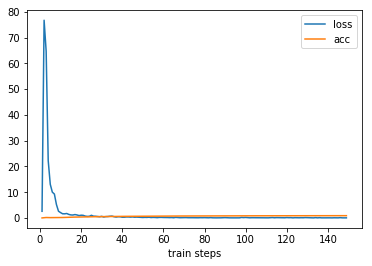

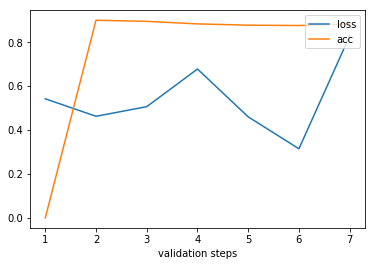

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt




plt.plot(range(1,len(train_loss)+1), train_loss)
plt.plot(range(1,len(train_acc)+1), train_acc)
plt.xlabel('train steps')
plt.ylabel('')
plt.legend(['loss', 'acc'], loc='upper right')
plt.show()

plt.figure()
plt.plot(range(1,len(val_loss)+1), val_loss)
plt.plot(range(1,len(val_acc)+1), val_acc)
plt.xlabel('validation steps')
plt.ylabel('')
plt.legend(['loss', 'acc'], loc='upper right')
plt.show()





In [11]:
# test prediction 
# Define the input function for prediction
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_test[0:1]},shuffle=False)
# Use the Estimator 'predict' method
predictions = model.predict(input_fn)

for p in predictions:
    print("actual :",classnames[int(y_test[0])],"predicted:",classnames[p])
  

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tfmodel1/model.ckpt-149
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
actual : gloves predicted: gloves


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tfmodel1/model.ckpt-149
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


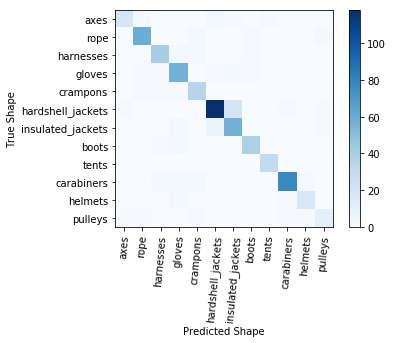

In [12]:
# SciKit-Learn confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_test},shuffle=False)

probabilities = model.predict(input_fn)

class_probabilities=[]

for p in probabilities:
    class_probabilities.append(p)
    

# Plot the confusion matrix
cm = confusion_matrix(y_test, class_probabilities)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.show()

In [13]:
def predict_image(classifier, img):
    import numpy as np
    
    # Flatten the image data to correct feature format
    imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    
    input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': imgfeatures},shuffle=False)

   

    # Use the classifier to predict the class
    predicted_class = classifier.predict(input_fn)
    print(predicted_class)
    result=[]
    for p in predicted_class:
        result.append(p)
  
    return result

In [14]:
# Resize image
def resize_image(img, size):
    from PIL import Image, ImageOps 
    
    # Convert RGBA images to RGB
    if np.array(img).shape[2] == 4:
        img = img.convert('RGB')
        
    # resize the image
    img.thumbnail(size, Image.ANTIALIAS)
    newimg = Image.new("RGB", size, (255, 255, 255))
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
    
    return newimg



<generator object Estimator.predict at 0x7fd2482a5728>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tfmodel1/model.ckpt-149
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
<generator object Estimator.predict at 0x7fd2482a53b8>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tfmodel1/model.ckpt-149
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
<generator object Estimator.predict at 0x7fd2850f7d58>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tfmodel1/model.ckpt-149
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
<generator object Estimator.predict at 0x7fd2850f7eb

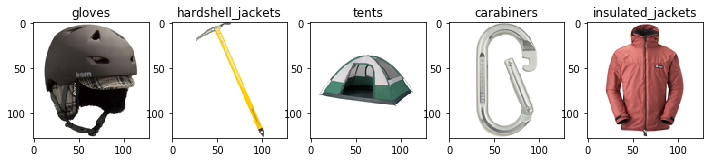

In [15]:
# Predict class for new data
from PIL import Image, ImageOps
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

image_urls = []
image_urls.append('https://i.stack.imgur.com/5I4Rx.jpg')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://www.buffalosystems.co.uk/wp-content/uploads/2012/06/zoom_apline_jacket_dark_russet-2365x3286.jpg')

size = (128,128)

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for url_idx in range(len(image_urls)):
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    #pre-process the image so it matches the training set
    img = np.array(resize_image(img, size))
    class_idx = predict_image(model, img)
    class_name = classnames[class_idx[0]]
    a=fig.add_subplot(1,len(image_urls),url_idx+1)
    imgplot = plt.imshow(img)
    a.set_title(class_name)